# TREINO E VALIDAÇÃO DOS MODELOS

In [5]:
import numpy as np
import pandas as pd
# from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier



import sys
import os

# Adiciona o diretório pai (onde está dropout_rate_project) ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Isso permite que o notebook enxergue a pasta dropout_rate_project.

from dropout_rate_project.py_files import data_prepared as dp
from dropout_rate_project.py_files import adjusted_models_util as amu
from dropout_rate_project.py_files import define_models_util as dmu



In [6]:
def get_params_result_best_model(features_train, target_train, pipeline, param_grid_01=None, param_grid_02=None, param_grid_03=None):

  best_hyperparams = None
  best_scores = None
  print(param_grid_01)
  if param_grid_01 is not None:
    print("Features_train shape:", features_train.shape)
    print("Target_train shape:", target_train.shape)
    best_params_01, best_score_01 = amu.get_best_hiper_params(
        features_train,
        target_train,
        pipeline,
        param_grid_01)
  print(param_grid_01)

  if param_grid_02 is not None:
    best_params_02, best_score_02 = amu.get_best_hiper_params(
      features_train,
      target_train,
      pipeline,
      param_grid_02)
  print(param_grid_02)

  if param_grid_03 is not None:
    best_params_03, best_score_03 = amu.get_best_hiper_params(
      features_train,
      target_train,
      pipeline,
      param_grid_03)
  print(param_grid_03)

  if all(param is not None for param in [param_grid_01, param_grid_02, param_grid_03]):
    best_hyperparams, best_scores = get_best_model(
        (best_params_01, best_score_01),
        (best_params_02, best_score_02),
        (best_params_03, best_score_03)
    )
  else:
   best_hyperparams, best_scores = get_best_model(
        (best_params_01, best_score_01)
    )

  print(best_hyperparams)
  print(best_scores)


  return best_hyperparams, best_scores

def get_best_model(*results):
    """
    Recebe múltiplas tuplas contendo (best_params, best_score)
    e retorna o conjunto de hiperparâmetros com o melhor score.

    Parâmetros:
        *results: Tuplas no formato (best_params, best_score)

    Retorno:
        O conjunto de hiperparâmetros com o maior best_score.
    """
    best_params, best_scores = max(results, key=lambda x: x[1])
    return best_params, best_scores

def train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test):
    # EXPLORAÇÃO DOS MELHORES HIPERPARÂMETROS ENCONTRADOS
    # Explorando os hiperparamentros com pipeline e class weight balanced
    # Criando um pipeline
    param_grid_01 = None
    param_grid_02 = None
    param_grid_03 = None

    if model_test == "Logistic_Regression":

        label_pipeline, base_model = dmu.get_base_model_logistic_regression()
        params_grid = dmu.get_params_logistic_regression()
        param_grid_01 = params_grid[0]
        param_grid_02 = params_grid[1]
        param_grid_03 = params_grid[2]

    
    if model_test == "Decision_Tree":

        label_pipeline, base_model = dmu.get_base_model_decision_tree()
        params_grid = dmu.get_params_decision_tree()
        param_grid_01 = params_grid[0]

    if model_test == "Random_Forest":

        label_pipeline, base_model = dmu.get_base_model_random_forest()
        params_grid = dmu.get_params_random_forest()
        param_grid_01 = params_grid[0]
    
    if model_test == "Support_Vector_Machine":
        label_pipeline, base_model = dmu.get_base_model_svm()
        params_grid = dmu.get_params_svm()
        param_grid_01 = params_grid[0]

    if model_test == "XG_Boost":
        label_pipeline, base_model = dmu.get_base_model_xgboost(reference_year)
        params_grid = dmu.get_params_xgboost()
        param_grid_01 = params_grid[0]

    if model_test == "KNN":
        label_pipeline, base_model = dmu.get_base_model_knn()
        params_grid = dmu.get_params_knn()
        param_grid_01 = params_grid[0]

    preprocessor = amu.create_preprocessor(features_train)
    print(preprocessor)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), (label_pipeline, base_model )])
    best_hyperparams_grid_search, best_scores_grid_search = get_params_result_best_model(features_train, target_train,pipeline, param_grid_01, param_grid_02, param_grid_03)
    print(best_hyperparams_grid_search)
    
    if model_test == "Logistic_Regression":
        l1_ratio=None
        if best_hyperparams_grid_search['logreg__penalty'] =='elasticnet': 
            l1_ratio=best_hyperparams_grid_search['logreg__l1_ratio']
            print("logreg__penalty")
            print(best_hyperparams_grid_search['logreg__penalty'])
        
        else:
            l1_ratio = None
            chosen_model = LogisticRegression(
            C=best_hyperparams_grid_search['logreg__C'],
            max_iter=best_hyperparams_grid_search['logreg__max_iter'],
            penalty=best_hyperparams_grid_search['logreg__penalty'],
            solver=best_hyperparams_grid_search['logreg__solver'],
            l1_ratio=l1_ratio,
            class_weight='balanced',
            random_state= random_state,
            fit_intercept=True)

    if model_test == "Decision_Tree":

        chosen_model = DecisionTreeClassifier(
            criterion = best_hyperparams_grid_search['decision_tree__criterion'],
            max_depth = best_hyperparams_grid_search['decision_tree__max_depth'],
            min_samples_split = best_hyperparams_grid_search['decision_tree__min_samples_split'],
            min_samples_leaf = best_hyperparams_grid_search['decision_tree__min_samples_leaf'],
            max_features = best_hyperparams_grid_search['decision_tree__max_features'],
            class_weight='balanced',
            random_state= random_state)
    
    if model_test == "Random_Forest":

        chosen_model = RandomForestClassifier(
            n_estimators = best_hyperparams_grid_search['random_forest__n_estimators'],
            criterion = best_hyperparams_grid_search['random_forest__criterion'],
            max_depth = best_hyperparams_grid_search['random_forest__max_depth'],
            min_samples_split = best_hyperparams_grid_search['random_forest__min_samples_split'],
            min_samples_leaf = best_hyperparams_grid_search['random_forest__min_samples_leaf'],
            max_features = best_hyperparams_grid_search['random_forest__max_features'],
            bootstrap = best_hyperparams_grid_search['random_forest__bootstrap'],
            class_weight='balanced',
            random_state= random_state)
    
    if model_test == "Support_Vector_Machine":
        chosen_model = SVC(
            C=best_hyperparams_grid_search['svm__C'],
            kernel=best_hyperparams_grid_search['svm__kernel'],
            gamma=best_hyperparams_grid_search['svm__gamma'],
            degree=best_hyperparams_grid_search.get('svm__degree', 3),  # Apenas para kernel 'poly'
            class_weight='balanced',
            probability=True,
            random_state=random_state
            )
    if model_test == "XG_Boost":
        scale_pos_weight_val = base_model.get_params()['scale_pos_weight']

        chosen_model = XGBClassifier(
            n_estimators=best_hyperparams_grid_search['xgboost__n_estimators'],
            max_depth=best_hyperparams_grid_search['xgboost__max_depth'],
            learning_rate=best_hyperparams_grid_search['xgboost__learning_rate'],
            #subsample=best_hyperparams_grid_search['xgboost__subsample'],
            #colsample_bytree=best_hyperparams_grid_search['xgboost__colsample_bytree'],
            gamma=best_hyperparams_grid_search['xgboost__gamma'],
            reg_alpha=best_hyperparams_grid_search['xgboost__reg_alpha'],
            reg_lambda=best_hyperparams_grid_search['xgboost__reg_lambda'],
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight_val,
            random_state=random_state
        )

    if model_test == "KNN":
        chosen_model = KNeighborsClassifier(
            n_neighbors=best_hyperparams_grid_search['knn__n_neighbors'],
            weights=best_hyperparams_grid_search['knn__weights'],
            metric=best_hyperparams_grid_search['knn__metric'],
            p=best_hyperparams_grid_search.get('knn__p', 2)  # Padrão é 2 (distância Euclidiana)
        )

    X = features_train
    y = target_train
    
    pipeline, y_pred_prob, optimal_threshold, best_threshold_tpr, best_tpr, best_threshold_accuracy, best_accuracy, scores_roc_auc_ovo, scores_recall, scores_accuracy  = evaluate_model_performance(chosen_model, X, y)
    
    
    save_result_txt(
    reference_year, drop_year, data_filter_sub, concat_inputs, model_test,
    categorical_features, numerical_features,
    label_pipeline, base_model, chosen_model,
    params_grid, best_hyperparams_grid_search, best_scores_grid_search,
    best_threshold_accuracy, scores_roc_auc_ovo, scores_recall
)

def evaluate_model_performance(model, X, y):
    pipeline, scores_roc_auc_ovo, scores_recall, scores_accuracy, optimal_threshold = amu.get_pipeline_created_and_evaluated(model, X, y)

    y_pred_prob, optimal_threshold, best_threshold_tpr, best_tpr, best_threshold_accuracy, best_accuracy = amu.evaluate_and_plot_roc_curve_cv(pipeline, X, y, cv=10)

    return pipeline, y_pred_prob, optimal_threshold, best_threshold_tpr, best_tpr, best_threshold_accuracy, best_accuracy, scores_roc_auc_ovo, scores_recall, scores_accuracy

def save_result_txt(
    reference_year, drop_year, data_filter_sub, concat_inputs, model_test,
    categorical_features, numerical_features,
    label_pipeline, base_model, chosen_model,
    params_grid, best_hyperparams_grid_search, best_scores_grid_search,
    best_threshold_accuracy, scores_roc_auc_ovo, scores_recall
):
    # Criando nome do arquivo com base nos parâmetros
    filename = f"{reference_year}_{drop_year}_{data_filter_sub}_{concat_inputs}_{model_test}.txt"
    
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(f"{reference_year}, {drop_year}, {data_filter_sub}, {concat_inputs}, {model_test}\n")
        file.write(f"categorical_features: {categorical_features}\n")
        file.write(f"numerical_features: {numerical_features}\n\n")

        file.write("label_pipeline: " + label_pipeline + "\n")
        file.write("base_model: " + str(base_model) + "\n")
        file.write("chosen_model: " + str(chosen_model) + "\n")
        file.write("chosen_model.get_params():\n")
        file.write(str(chosen_model.get_params()) + "\n\n")

        file.write("Grid Params: " + str(params_grid) + "\n")
        file.write("best hyperparams grid: " + str(best_hyperparams_grid_search) + "\n")
        file.write("best score grid params: " + str(best_scores_grid_search) + "\n")
        file.write("optimal threshold accuracy: " + str(best_threshold_accuracy) + "\n\n")

        file.write(f"Scores de roc_curve: {[round(score_i, 2) for score_i in scores_roc_auc_ovo]}\n")
        file.write(f"Média de roc_curve: {scores_roc_auc_ovo.mean():.2f}\n")
        file.write(f"Desvio padrão de roc_curve: {scores_roc_auc_ovo.std():.2f}\n\n")

        file.write(f"Scores de recall: {[round(score_i, 2) for score_i in scores_recall]}\n")
        file.write(f"Média de recall: {scores_recall.mean():.2f}\n")
        file.write(f"Desvio padrão de recall: {scores_recall.std():.2f}\n")

    print(f"Arquivo salvo como: {filename}")


In [7]:
# Configuração dos dados

dados = '../data/selected_data.csv'
# Gráficos para variáveis categóricas
categorical_features = ['RF-CAT', 'SEXO', 'TC', 'NC', 'TO', 'ME', 'TURNO']
# Gráficos para variáveis numéricas
numerical_features = ['IDA-MÉD']
df = None

# Modelo para avaliação
label_pipeline = None
base_model = None
params_grid = None
param_grid_01 = None
param_grid_02 = None
param_grid_03 = None
chosen_model = None
best_hyperparams_grid_search = None
best_scores_grid_search = None
random_state = 0

def read_data(data_filter_sub, concat_inputs):
  # Caminho para carregar o arquivo do Google Drive
  df = pd.read_csv(dados)

  if data_filter_sub:
    # Exemplo de uso:
    df_filtrado = dp.filter_dataframe_by_column(df, 'TO', 'SUB')
    df=df_filtrado
    print(df_filtrado)

  if concat_inputs:
    df["RFCAT_SEXO_TC_NC_TO_ME_TURNO"] = df[["RF-CAT","SEXO","TC", "NC", "TO", "ME", "TURNO"]].astype(str).agg("-".join, axis=1)
    df = df[["IDA-MÉD","RFCAT_SEXO_TC_NC_TO_ME_TURNO","ANO","AE"]]
    categorical_features = ["IDA-MÉD","RFCAT_SEXO_TC_NC_TO_ME_TURNO"]

  df_train, df_test, features_train, target_train, features_test, target_test = dp.get_df_train_df_test(df, reference_year, drop_year )

  print("Shape df final:", df.shape)

  return df, df_train, df_test, features_train, target_train, features_test, target_test


In [4]:
reference_year = 2019
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2019
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


reference_year = 2020
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2020
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "Support_Vector_Machine"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


print("XG_Boost")

reference_year = 2018
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2018
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


reference_year = 2019
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2019
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


reference_year = 2020
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2020
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)



print("KNN")

reference_year = 2018
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2018
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


reference_year = 2019
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2019
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


reference_year = 2020
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2020
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2021
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2022
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[2020]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)

reference_year = 2023
drop_year=[]
data_filter_sub = True
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)



df_train shape: (967, 9)
features_train shape: (967, 8)
target_train shape: (967,)
Shape df final: (5719, 10)
Shape df final: (5719, 10)
ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['IDA-MÉD'], dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['RF-CAT', 'SEXO', 'TC', 'NC', 'TO', 'ME', 'TURNO'], dtype='object'))])
{'svm__C': [0.1, 0.5, 1], 'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'svm__gamma': ['scale', 'auto'], 'svm__degree': [2, 3, 4]}
Features_train shape: (967, 8)
Target_train shape: (967,)


KeyboardInterrupt: 

df_train shape: (3806, 9)
features_train shape: (3806, 8)
target_train shape: (3806,)
Shape df final: (5719, 10)
Shape df final: (5719, 10)
ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['IDA-MÉD'], dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['RF-CAT', 'SEXO', 'TC', 'NC', 'TO', 'ME', 'TURNO'], dtype='object'))])
{'xgboost__n_estimators': [100, 250], 'xgboost__max_depth': [3, 5, 7], 'xgboost__learning_rate': [0.01, 0.1, 0.2], 'xgboost__gamma': [0, 0.1, 0.2], 'xgboost__reg_alpha': [0, 0.1, 1], 'xgboost__reg_lambda': [1, 1.5, 2]}
Features_train shape: (3806, 8)
Target_train shape: (3806,)
Melhores hiperparâmetros: {'xgboost__gamma': 0.1, 'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 250, 'xgboost__reg_alpha': 0.1, 'xgboost__reg_lambda': 1}
Melhor score: 0.7349340274489128
{'xgboost__n_estimators': [100, 250], '

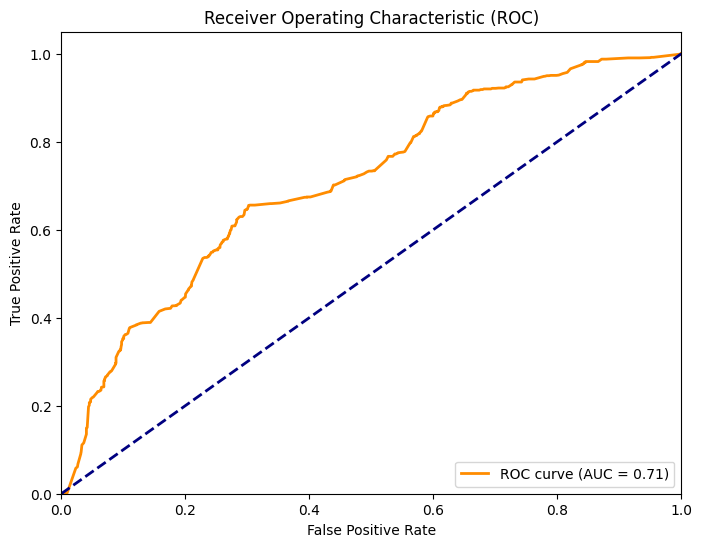

Arquivo salvo como: 2023_[2020]_False_False_XG_Boost.txt


In [9]:
reference_year = 2023
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "XG_Boost"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)


df_train shape: (3806, 9)
features_train shape: (3806, 8)
target_train shape: (3806,)
Shape df final: (5719, 10)
Shape df final: (5719, 10)
ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['IDA-MÉD'], dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['RF-CAT', 'SEXO', 'TC', 'NC', 'TO', 'ME', 'TURNO'], dtype='object'))])
{'knn__n_neighbors': [3, 5, 7, 9], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['euclidean', 'manhattan', 'minkowski'], 'knn__p': [1, 2]}
Features_train shape: (3806, 8)
Target_train shape: (3806,)


d:\Dropbox\Documentos\IFPB\Pesquisa\Taxa de Evasão\Dropout Rate Project\dropout_rate_project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Dropbox\Documentos\IFPB\Pesquisa\Taxa de Evasão\Dropout Rate Project\dropout_rate_project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Melhores hiperparâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}
Melhor score: 0.6633026096492599
{'knn__n_neighbors': [3, 5, 7, 9], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['euclidean', 'manhattan', 'minkowski'], 'knn__p': [1, 2]}
None
None
{'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}
0.6633026096492599
{'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'uniform'}


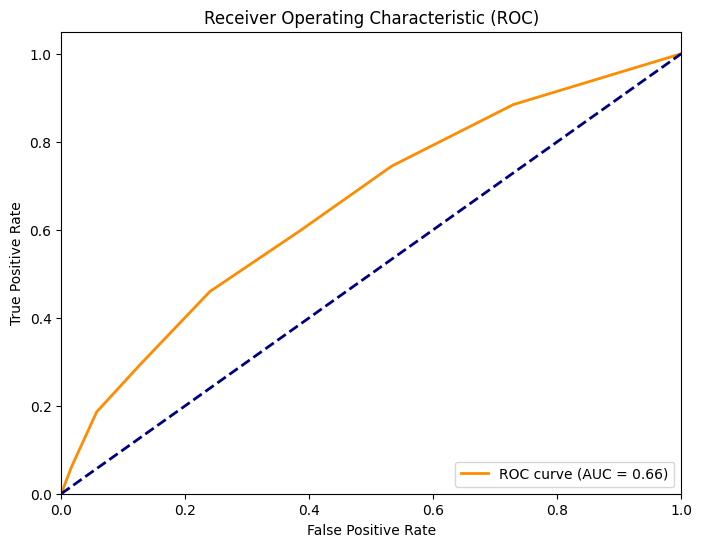

Arquivo salvo como: 2023_[2020]_False_False_KNN.txt


In [10]:
reference_year = 2023
drop_year=[2020]
data_filter_sub = False
concat_inputs = False
model_test = "KNN"
df, df_train, df_test, features_train, target_train, features_test, target_test = read_data(data_filter_sub, concat_inputs)
print("Shape df final:", df.shape)
train_validationg_models(categorical_features, numerical_features, features_train, target_train, random_state, reference_year, drop_year,data_filter_sub, concat_inputs, model_test)
